In [61]:
%reload_ext autoreload
%autoreload 2

import torch

torch.manual_seed(42)


In [62]:
from data.names_data_source import NamesDataSource
from data.tokenizer import Tokenizer
from learning.names_generator.names_generator_dataset import NamesGeneratorDataset


tokenizer = Tokenizer(use_start_token=True, use_end_token=True)

names_data_source = NamesDataSource.load(
    data_folder="../datasets/names",
    tokenizer=tokenizer,
    normalize_unicode=True,
)
print(tokenizer.token_to_index)

names_dataset = NamesGeneratorDataset(names_data_source, tokenizer)
sample = names_dataset[0]
print(sample)


{'<|pad|>': 0, '<|start|>': 1, '<|end|>': 2, ' ': 3, "'": 4, '-': 5, 'A': 6, 'B': 7, 'C': 8, 'D': 9, 'E': 10, 'F': 11, 'G': 12, 'H': 13, 'I': 14, 'J': 15, 'K': 16, 'L': 17, 'M': 18, 'N': 19, 'O': 20, 'P': 21, 'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'W': 28, 'X': 29, 'Y': 30, 'Z': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, 'ß': 58, 'ł': 59}
NameSample(input=tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

[108, 246, 502, 286, 3668, 273, 690, 193, 226, 701, 990, 94, 138, 74, 9340, 100, 293, 71]
[0, 0, 0, 43, 82, 25, 1523, 1411, 656, 885, 455, 471, 915, 976, 206, 791, 849, 757, 1352, 479, 338, 910, 28, 718, 1127, 1079, 141, 741, 307, 12, 428, 538, 12554, 1757, 2327, 2616, 9805, 1042, 1967, 5907, 9484, 484, 5765, 5676, 2453, 8887, 10136, 763, 37, 6664, 5781, 4438, 4103, 5544, 756, 59, 3038, 1289, 8, 1]


<BarContainer object of 60 artists>

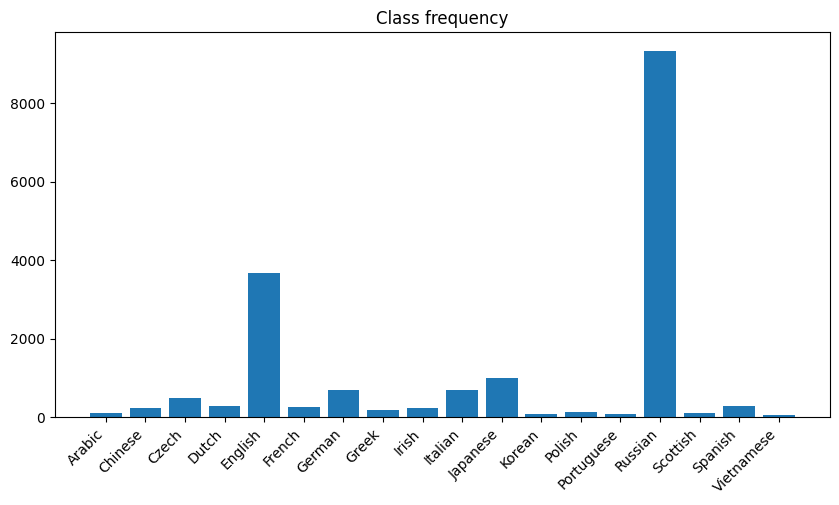

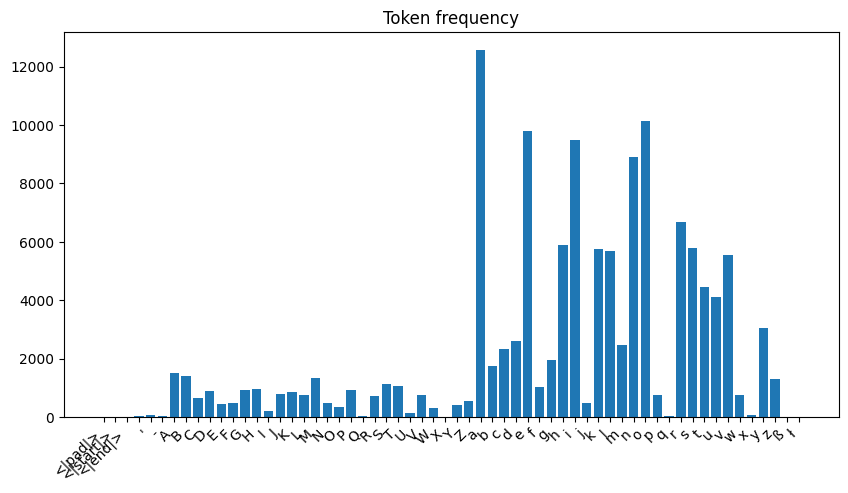

In [63]:
import matplotlib.pyplot as plt

category_frequency = names_data_source.class_frequency()
print(category_frequency)

token_frequency = names_data_source.token_frequency()
print(token_frequency)

_, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Class frequency")
ax.set_xticks(range(len(category_frequency)))
ax.set_xticklabels(names_data_source.countries, rotation=45, ha="right")
ax.bar(range(len(category_frequency)), category_frequency)

_, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Token frequency")
ax.set_xticks(range(len(token_frequency)))
ax.set_xticklabels(tokenizer.index_to_token, rotation=45, ha="right")
ax.bar(range(len(token_frequency)), token_frequency)


In [55]:
train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 15294
Test dataset size: 2698


In [ ]:
train_sampler_weights = [
    1 / token_frequency[int(sample.input.argmax().item())] for sample in train_dataset
]
print(train_sampler_weights[10000:10010])

criterion_weights = 1 / torch.tensor(category_frequency) ** 0.5
criterion_weights /= criterion_weights.sum()
print(criterion_weights)


[0.010347288589592779, 0.010347288589592779, 0.016511454667095662, 0.016511454667095662, 0.03806934938134405, 0.010347288589592779, 0.010347288589592779, 0.016511454667095662, 0.03178208630818641, 0.010347288589592779]
tensor([0.0816, 0.0540, 0.0378, 0.0501, 0.0140, 0.0513, 0.0323, 0.0610, 0.0564,
        0.0320, 0.0269, 0.0874, 0.0722, 0.0985, 0.0088, 0.0848, 0.0495, 0.1013])


In [57]:
from learning.names_generator.model import NamesGenerator
import torch
import torch.nn as nn


def generate_name(model: NamesGenerator, country_idx: int):
    with torch.no_grad():
        # shape: [1, C]
        category_tensor = names_dataset.country_index_to_one_hot(country_idx).unsqueeze(
            0
        )

        # shape: [1, H]
        hidden_tensor = model.init_hidden()

        # shape: [1, V]
        input_tensor = tokenizer.to_one_hot(Tokenizer.START_TOKEN)

        output_names = []
        for i in range(50):
            # shape: [1, V]
            output, hidden_tensor = model(category_tensor, input_tensor, hidden_tensor)

            probs = torch.exp(output)
            idx = int(torch.multinomial(probs, num_samples=1).item())

            if tokenizer.is_special_idx(idx):
                break

            next_char = tokenizer.index_to_token[idx]
            output_names.append(next_char)
            input_tensor = tokenizer.to_one_hot(next_char)

        return "".join(output_names)


test_names_generator = NamesGenerator(
    hidden_size=128,
    num_vocab=tokenizer.vocab_size,
    num_classes=names_data_source.num_classes,
)
for _ in range(10):
    print(generate_name(test_names_generator, 4))


łsdeł
yłnmeł'
ß-hbumgjds'hdxßßm'yubpceasdłnguijyq
andy
k
cvevpzddiłnh'ofnm--
fq
yłw jhcvd'z-ajaßfaf  eßggnokha

orrybv' r w


In [58]:
import time
import math
import torch
from learning.names_generator.model import (
    Batch,
    ParallelBatchLearner,
    SequentialBatchLearner,
    NamesGenerator,
)
from learning.metrics import (
    ConfusionMatrixMetric,
)

from torch.utils.data import DataLoader, WeightedRandomSampler

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 256
NUM_EPOCHS = 500
PATIENCE = 20

model = NamesGenerator(
    num_classes=names_data_source.num_classes,
    num_vocab=tokenizer.vocab_size,
    hidden_size=HIDDEN_SIZE,
)
print(model)
pad_token_idx = tokenizer.token_to_index[Tokenizer.PAD_TOKEN]
criterion = nn.CrossEntropyLoss(reduction="sum", ignore_index=pad_token_idx)
print(criterion)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

learner = ParallelBatchLearner(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    padding_idx=pad_token_idx,
)
print(learner)

train_sampler = WeightedRandomSampler(
    weights=train_sampler_weights,
    num_samples=len(train_dataset),
    replacement=True,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Batch.from_samples,
)

eval_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Batch.from_samples,
)

train_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)
eval_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)

print(
    "Starting training...\n"
    f"Expecting initial loss around {math.log(tokenizer.vocab_size)}"
)
start_time = time.time()
train_losses, eval_losses = learner.fit(
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_metrics=[train_confusion_matrix_metric],
    eval_metrics=[eval_confusion_matrix_metric],
)
elapsed_time = time.time() - start_time
print(f"Training completed. Elapsed time: {elapsed_time:.2f}s")


NamesGenerator(
  (i2h): MLP(
    (norm): LayerNorm((308,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=308, out_features=256, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (i2o): MLP(
    (norm): LayerNorm((308,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=308, out_features=34, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (o2o): MLP(
    (norm): LayerNorm((290,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=290, out_features=34, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Starting training...
Ex

KeyboardInterrupt: 

### RESEARCH LOG

In DESC ordering

#### Experiment 4

```
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 256
NUM_EPOCHS = 500
PATIENCE = 10
```

Result:
- 27/500 -- 3.50s 	Train loss 	1.9281 	Eval loss 	2.1096 	
- Training completed. Elapsed time: 96.83s

#### Experiment 3
Add LayerNorm
```
NamesGenerator(
  (i2h): Linear(in_features=334, out_features=256, bias=True)
  (i2h_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (i2h_gelu): GELU(approximate='none')
  (i2o): Linear(in_features=334, out_features=60, bias=True)
  (i2o_layer_norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  (i2o_gelu): GELU(approximate='none')
  (o2o): Linear(in_features=316, out_features=60, bias=True)
  (o2o_layer_norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  (o2o_gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
```
Result:
- 70/500 -- 3.57s 	Train loss 	2.1711 	Eval loss 	2.2408 	
- Training completed. Elapsed time: 251.79s
- Gets to similar result in about half the time.

#### Experiment 2
Added GELU
```
NamesGenerator(
  (i2h): Linear(in_features=334, out_features=256, bias=True)
  (i2h_gelu): GELU(approximate='none')
  (i2o): Linear(in_features=334, out_features=60, bias=True)
  (i2o_gelu): GELU(approximate='none')
  (o2o): Linear(in_features=316, out_features=60, bias=True)
  (o2o_gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
```
Result
- 223/500 -- 2.11s 	Train loss 	2.1839 	Eval loss 	2.1243 	
- Training completed. Elapsed time: 473.82s
- Slightly better result. The network seems to stop learning. Grad becomes too small at the end

#### Experiment 1
```
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 256
NUM_EPOCHS = 500
PATIENCE = 10
```
Result:
- 130/500 -- 1.71s 	Train loss 	2.2599 	Eval loss 	2.1352 	
- Training completed. Elapsed time: 223.06s

In [42]:
for _ in range(10):
    print(generate_name(model, 4))


tyh-han
VinnBall
Gouck
LavriMatt
Jallett
Fild
Tyler
Rashide
OlechMarłe'j
Wills


['<|pad|>', '<|start|>', '<|end|>', ' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'ł']


Text(0.5, 1.0, 'F1 Score')

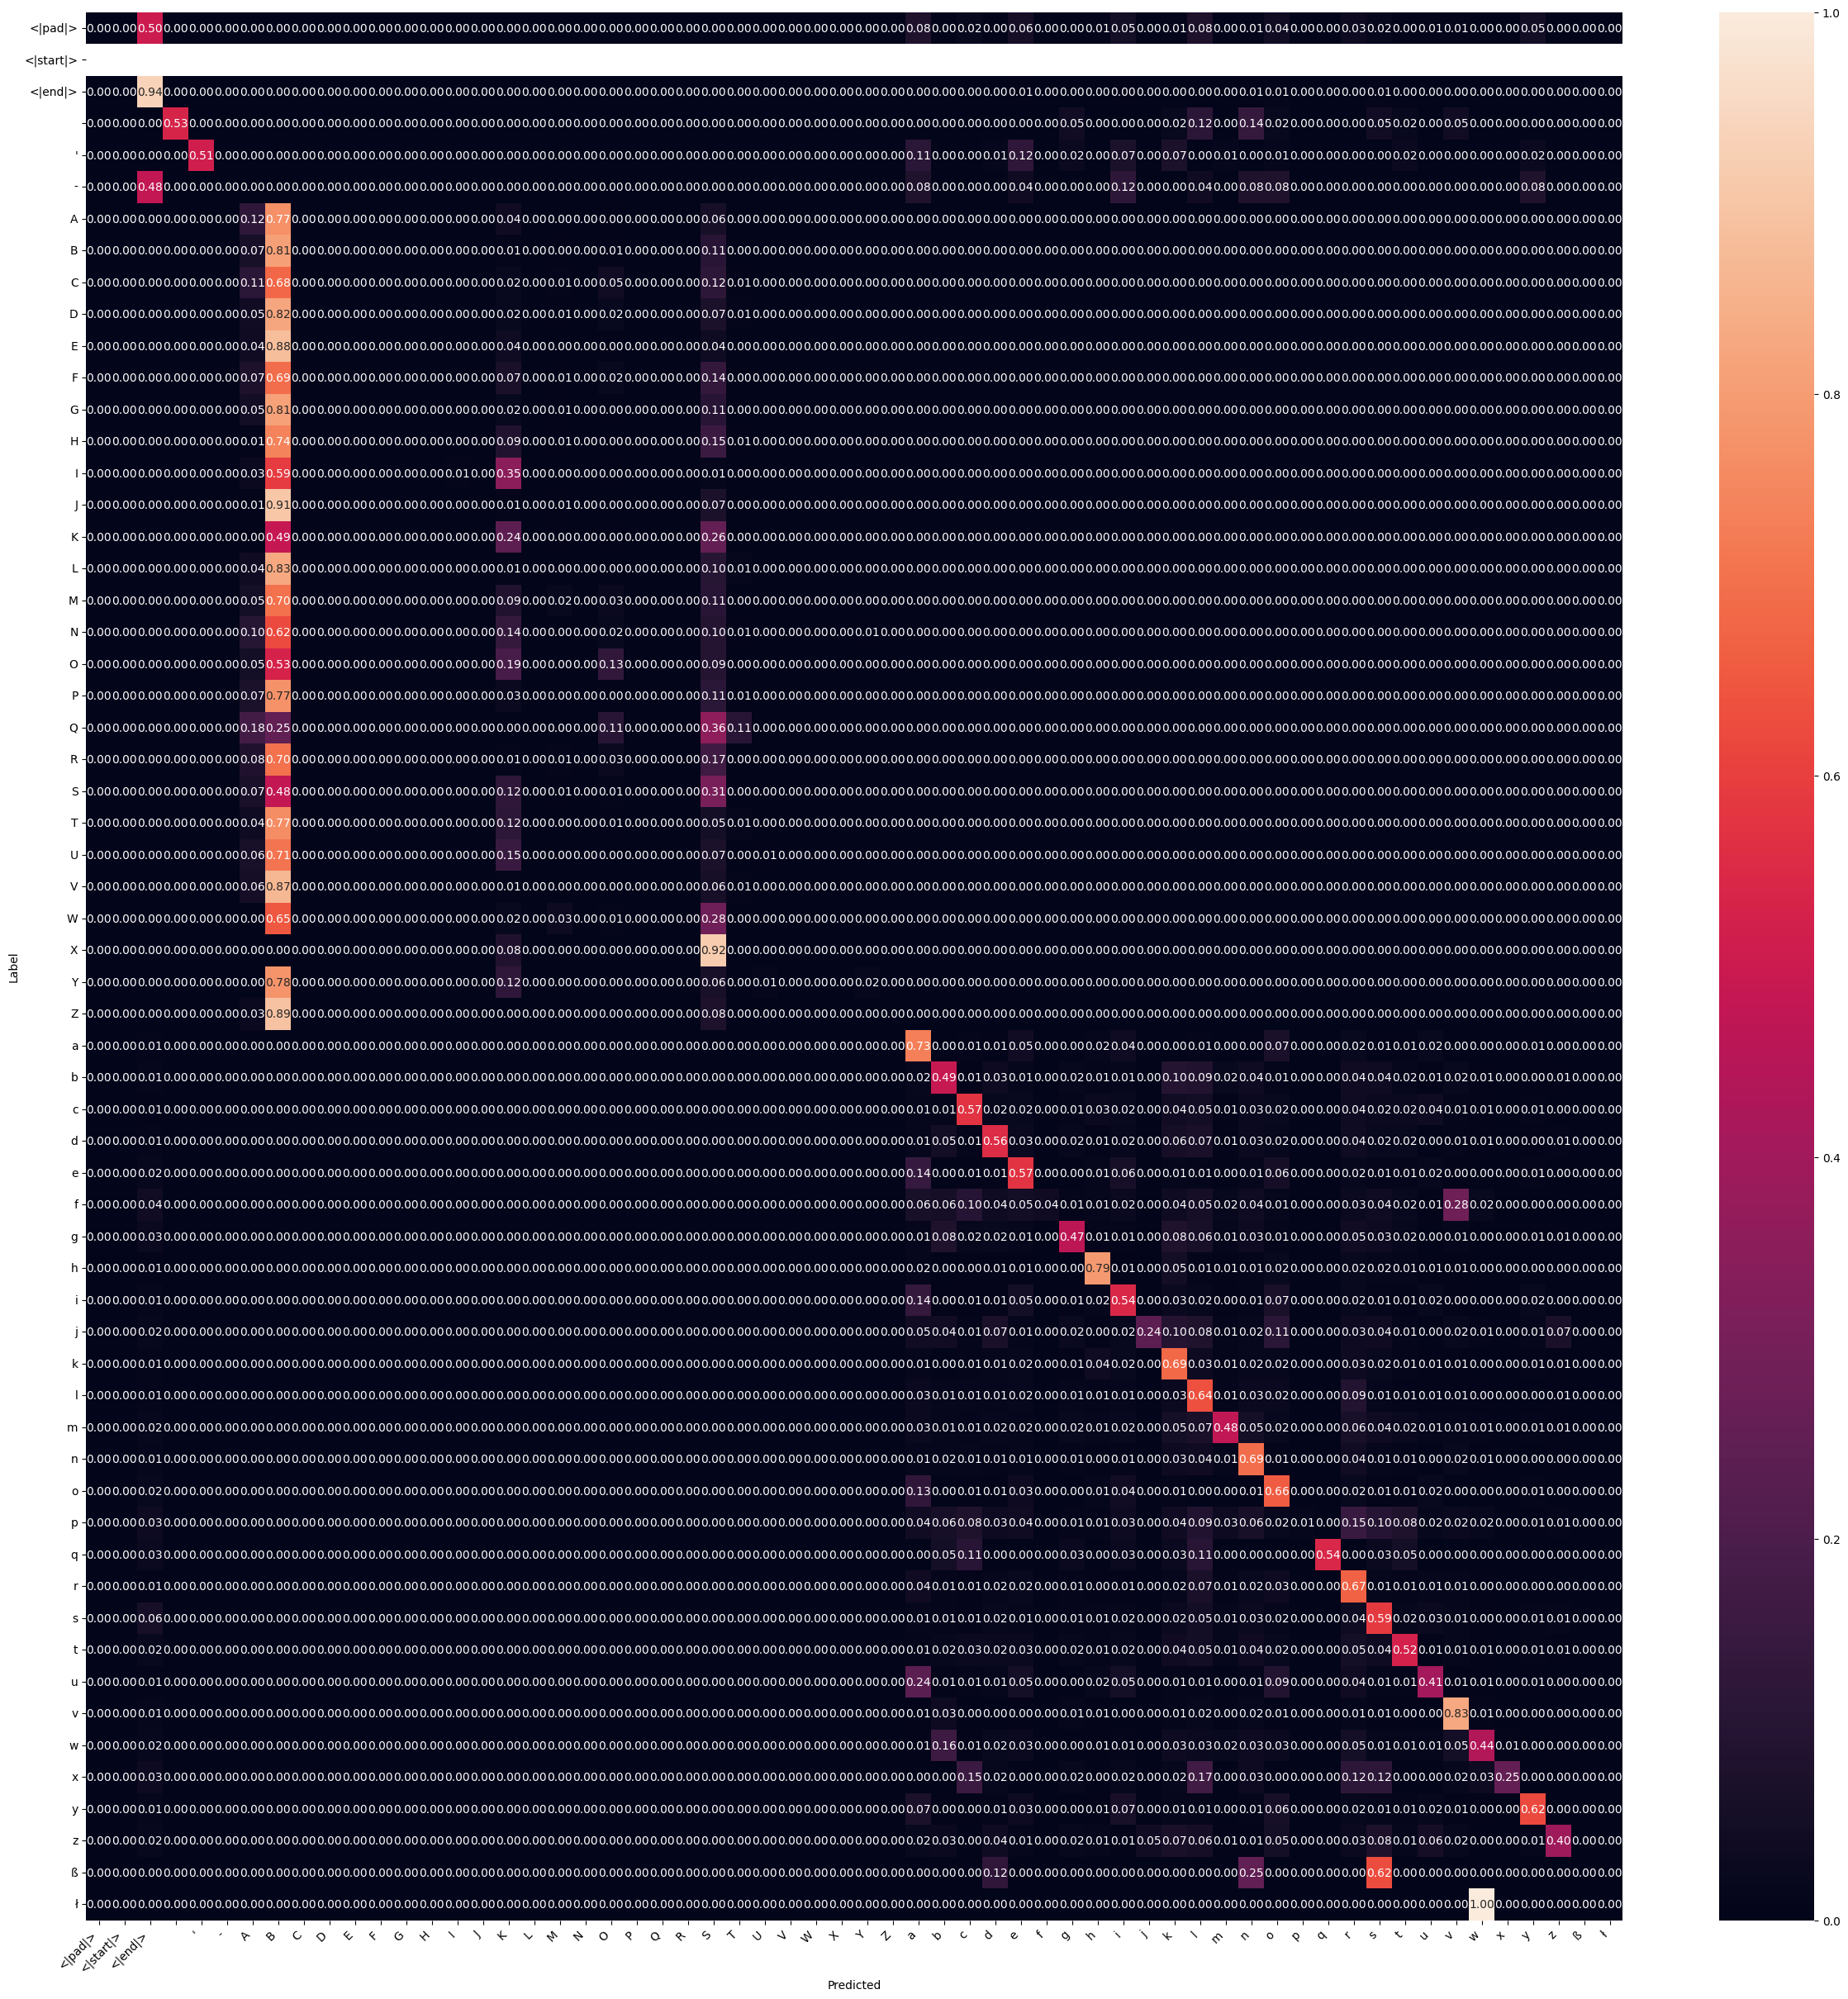

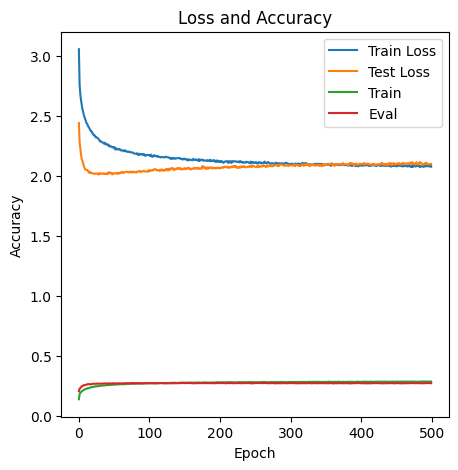

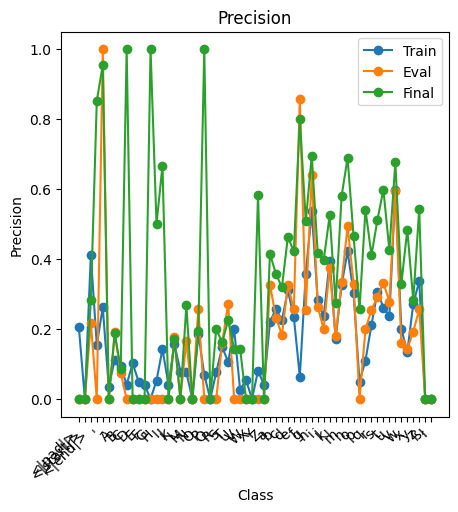

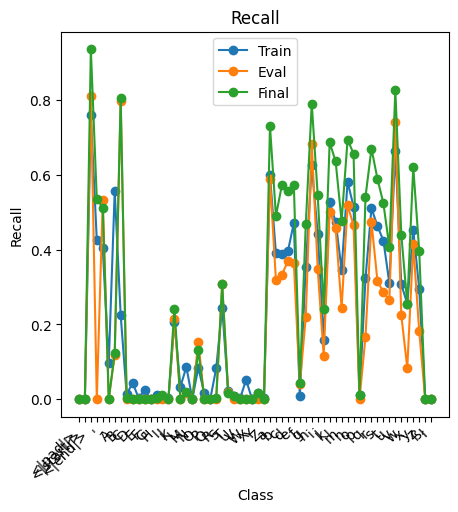

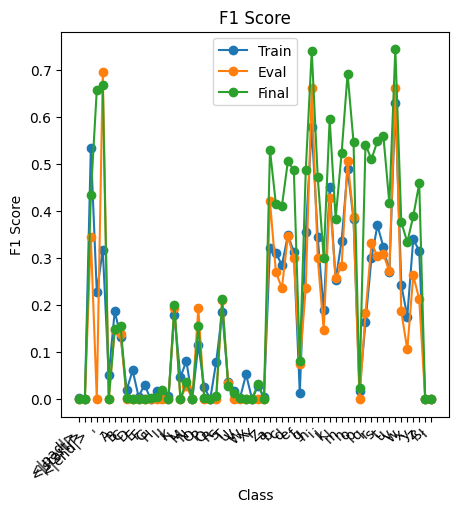

In [43]:
import matplotlib.pyplot as plt

print(tokenizer.index_to_token)

full_dataloader = DataLoader(
    dataset=names_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Batch.from_samples,
)
full_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)
final_loss = learner.final_eval(
    dataloader=full_dataloader, metrics=[full_confusion_matrix_metric]
)

_, ax = plt.subplots(figsize=(30, 30))
full_confusion_matrix_metric.plot_confusion_matrix(ax, normalize=True)

_, ax = plt.subplots(figsize=(5, 5))
ax.plot(train_losses, label="Train Loss")
ax.plot(eval_losses, label="Test Loss")
train_confusion_matrix_metric.plot_accuracies(ax, "Train")
eval_confusion_matrix_metric.plot_accuracies(ax, "Eval")
ax.set_title("Loss and Accuracy")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_precisions(ax, "Train")
eval_confusion_matrix_metric.plot_class_precisions(ax, "Eval")
full_confusion_matrix_metric.plot_class_precisions(ax, "Final")
ax.set_title("Precision")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_recalls(ax, "Train")
eval_confusion_matrix_metric.plot_class_recalls(ax, "Eval")
full_confusion_matrix_metric.plot_class_recalls(ax, "Final")
ax.set_title("Recall")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_f1_scores(ax, "Train")
eval_confusion_matrix_metric.plot_class_f1_scores(ax, "Eval")
full_confusion_matrix_metric.plot_class_f1_scores(ax, "Final")
ax.set_title("F1 Score")


NamesGenerator(
  (i2h): MLP(
    (norm): LayerNorm((590,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=590, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (i2o): MLP(
    (norm): LayerNorm((590,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=590, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (o2o): MLP(
    (norm): LayerNorm((572,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=572, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


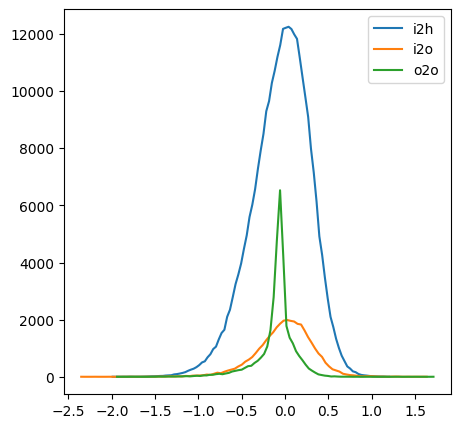

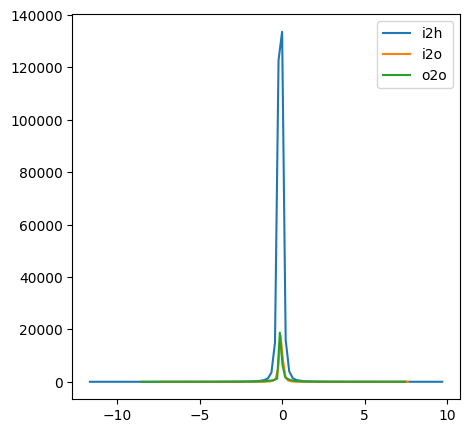

In [44]:
print(model)

with torch.no_grad():
    i2h_hist, i2h_edges = torch.histogram(model.i2h.fc.weight)
    i2o_hist, i2o_edges = torch.histogram(model.i2o.fc.weight)
    o2o_hist, o2o_edges = torch.histogram(model.o2o.fc.weight)

    f, ax = plt.subplots(figsize=(5, 5))
    ax.plot(i2h_edges[:-1], i2h_hist, label="i2h")
    ax.plot(i2o_edges[:-1], i2o_hist, label="i2o")
    ax.plot(o2o_edges[:-1], o2o_hist, label="o2o")
    ax.legend()

with torch.no_grad():
    i2h_hist, i2h_edges = torch.histogram(model.i2h.fc.weight.grad)
    i2o_hist, i2o_edges = torch.histogram(model.i2o.fc.weight.grad)
    o2o_hist, o2o_edges = torch.histogram(model.o2o.fc.weight.grad)

    f, ax = plt.subplots(figsize=(5, 5))
    ax.plot(i2h_edges[:-1], i2h_hist, label="i2h")
    ax.plot(i2o_edges[:-1], i2o_hist, label="i2o")
    ax.plot(o2o_edges[:-1], o2o_hist, label="o2o")
    ax.legend()